# Plotting Summary
Sherry Wong, 9 June 2021


This notebook serves the purpose of consolidating all code from Fall 2020-2021.

## 1. Plotting in Matplotlib

### 1.1 Read/load files
#### Save as .csv

### 1.2 Coordinate Setup
### 1.3 Data Setup
### 1.4 Zooming
### 1.5 Velocity Vector Fields

## 2. Plotting with YT
### 2.1 Zooming (w/ + w/o Cut Regions)
### 2.2 Velocity Vector Fields
### 2.3 Streamlines
### 2.4 Making gifs
### 2.5 Total MassS

### Import relevant packages:

In [1]:
import yt
from yt.units import kpc #for yt unit

import os #for file navigation
import os.path
from os import path

import shutil #remove excess files
import time #record runtime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm #for log scale

import moviepy #for gif making
from moviepy.editor import ImageSequenceClip #for gif making
import beepy #sound for when the code is done running
import numpy as np #for working with numbers


## 1. Plotting in Matplotlib
### 1.1 Read/load files:

In [2]:
import h5py

#This method reads in a file, and creates a dictionary of relevant variables.
def fileInputTest(fileName):
    f2 = h5py.File(fileName, 'r')

    print("\nReading file:")
    print(f2) #general info
    print(f2.attrs)
    print("\nKeys:")
    print(f2.keys())
    print()

    coords = f2['coordinates']
    cray = f2['cray']
    dens = f2['dens']
    magx = f2['magx']
    magy = f2['magy']
    magz = f2['magz']
    pres = f2['pres']
    velx = f2['velx']
    vely = f2['vely']
    velz = f2['velz']
    temp = f2['temp']

    dict = {
        "coordinates" : coords,
        "cray_pressure" : cray,
        "density" : dens,
        "magx" : magx,
        "magy" : magy,
        "magz" : magz,
        "pressure" : pres,
        "velx" : velx,
        "vely" : vely,
        "velz" : velz,
        "temp" : temp

    }
    return dict
    #END OF METHOD

#Full file path. Jupyter likes Windows notation, Spyder likes Mac/Linux
#Change the filename to see a different simulation time
filename = r"C:\Users\wongb\Documents\URS Data\m2_c1_16x8_64x64/More Plot Files/parkerCRs_hdf5_plt_cnt_0076"
#filename = "/mnt/c/Users/wongb/Documents/URS Data/m1.5_c1_16x16_128x128_Rodrigues_Streaming/More Plot Files/parkerCRs_hdf5_plt_cnt_0000"

dict = fileInputTest(filename)

#print(dict)
#print(dict['density'])


Reading file:
<HDF5 file "parkerCRs_hdf5_plt_cnt_0076" (mode r)>
<Attributes of HDF5 object at 1919628136512>

Keys:
<KeysViewHDF5 ['bflags', 'block size', 'bounding box', 'coordinates', 'cray', 'dens', 'gid', 'gsurr_blks', 'integer runtime parameters', 'integer scalars', 'logical runtime parameters', 'logical scalars', 'magx', 'magy', 'magz', 'node type', 'pres', 'processor number', 'real runtime parameters', 'real scalars', 'refine level', 'sim info', 'string runtime parameters', 'string scalars', 'temp', 'unknown names', 'velx', 'vely', 'velz', 'which child']>



#### Save as .csv if necessary
Commented out b/c data arrays haven't yet been initialised in the notebook, which will cause an error.

In [3]:
import csv #https://docs.python.org/3/library/csv.html#csv.Dialect

#write files for easier access later
#with open('m2_c1_0000_data.csv', 'w', newline='') as csvfile:
# fieldnames = ['posx', 'posy', 'velx', 'vely', 'mag', 'density']
# writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
# writer.writeheader()

# for i in range(0, 262143):
#     writer.writerow({'posx': posXarray[i], 'posy': posYarray[i], 
#                      'velx': velXarray[i], 'vely': velYarray[i], 
#                      'mag': color[i], 'density': densityArray[i]})

### 1.2 Coordinate Setup
#### Prelude:

The coordinate system for the FLASH simulation is a Z-order curve. It doesn't matter too much for our purposes, but it looks cool:

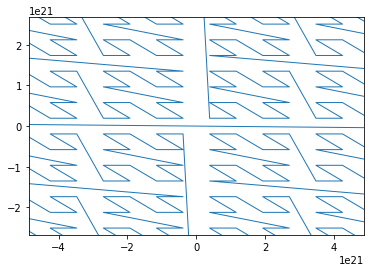

In [4]:
#recreate the z-order curve:
posX = [] #list
posY = [] #list
for coord in dict['coordinates']:
    posX.append(coord[0])
    posY.append(coord[1])
plt.plot(posX, posY, linewidth = 1)
plt.margins(x=-0.4, y=-0.39) #zoom
#plt.savefig('CoordPlot1.png'); #bad quality
#plt.savefig('CoordPlot1.svg'); #much better quality
###print("\nPlotting finished.")

#### Expanding coordinate grid

<img src="Data_8x8.png" width="300" style="float: right; padding-left: 30px">

The way that the data is set up, each single coordinate represents a 8x8 box of additional data points. Thus, in order to view the full resolution, it is necessary to expand the each coordinate into an 8x8 grid, with the original coordinate in the bottom left corner. The other data will populate these 8x8 grids.


Without this extra work, plots will be much less resolved:

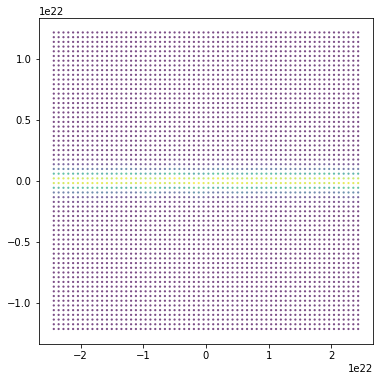

In [5]:
#First convert the HDF5 data into lists
posX = [] #list
posY = [] #list
for coord in dict['coordinates']:
    posX.append(coord[0])
    posY.append(coord[1])
    
density = [] #list
for dens in dict['density']:
     #a random point in the 8x8
    density.append(dens[0][4][4])
    
fig = plt.figure(figsize=(6, 6))
plt.scatter(posX, posY,
           linewidths=0, alpha=.7,
           edgecolor='k',
           s = 5,
           c=density)

#### Coordinate Setup Code
Lets do this properly. 

For each single XY point, we will create an 8x8 grid with the specified point in the bottom left (see image in expanding coordinate grid). Then we will flatten the grid to get two 1D XY arrays. We will calculate the offset based on the position of neighboring cells.

In [33]:
"""Sets up coordinates for 16384 * 64 data points."""
posX = [] #list
posY = [] #list
#these steps may differ between simulations
stepX = dict['coordinates'][1][0] - dict['coordinates'][0][0]
stepY = dict['coordinates'][2][1] - dict['coordinates'][1][1]

for coord in dict['coordinates']:
    
    #equally space x and y apart
    tempXlin = np.linspace(coord[0], coord[0] + stepX, 8)
    tempYlin = np.linspace(coord[1], coord[1] + stepY, 8)
    
    #create a grid of coordinates using these XY values
    tempMeshgrid = np.meshgrid(tempXlin, tempYlin)
    
    #append the full X and Y coordinate pairs
    posX.append(tempMeshgrid[0])
    posY.append(tempMeshgrid[1])
    
posXarray, posYarray = (np.asarray(posX), np.asarray(posY))
posXarray = posXarray.flatten()
posYarray = posYarray.flatten()

### 1.3 Data Setup
Now let's set up the actual data and load them into arrays. These don't require extra work; they are already expanded.

In [36]:
"""Density Setup"""
density = [] #list
for dens in dict['density']:
    density.append(dens) #shape=(1, 8, 8)
densityArray = np.asarray(density)
densityArray = densityArray.flatten()

""""Temp Setup"""
temp = [] #list
for thing in dict['temp']:
    temp.append(thing) #shape=(1, 8, 8)
tempArray = np.asarray(temp)
tempArray = tempArray.flatten()

"""Velocity Setup"""
velX = []
velY = []
for x in dict['velx']:
    velX.append(x)
for y in dict['vely']:
    velY.append(y)
velXarray = np.asarray(velX)
velYarray = np.asarray(velY)
velXarray = velXarray.flatten()
velYarray = velYarray.flatten()

Now we are ready to plot our data.

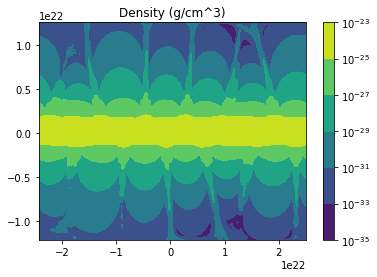

In [8]:
plt.title("Density (g/cm^3)")
plt.tricontourf(posXarray, posYarray, densityArray, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.colorbar(extend='both', orientation='vertical')

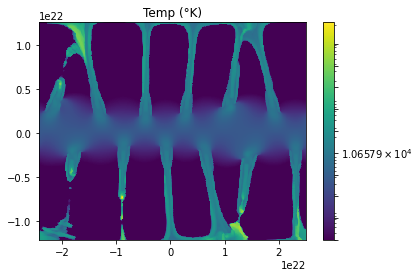

In [9]:
z=tempArray
plt.title("Temp (\N{DEGREE SIGN}K)")
# plt.title("Density (g/$cm^3$)")

lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarray, posYarray, z, locator=ticker.LogLocator(), levels = lev) #good for irregular Z values
plt.colorbar(extend='both', orientation='vertical')

### 1.4 Zooming in matplotlib
We can zoom into particular sections of a plot by applying limits to the data.

In [37]:
#The true/false table
TFtable = np.logical_and((pow(10, 22) < posXarray), (posYarray < 0))

#apply the true/false table to our data.
posXarrayZoom = posXarray[TFtable]
posYarrayZoom = posYarray[TFtable]
velXarrayZoom = velXarray[TFtable]
velYarrayZoom = velYarray[TFtable]
densityArrayZoom = densityArray[TFtable]
tempArrayZoom = tempArray[TFtable]

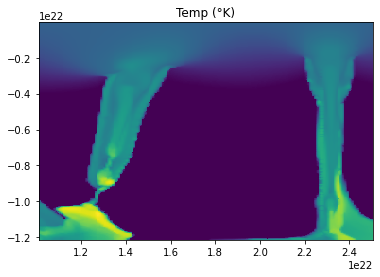

In [38]:
z=tempArrayZoom
plt.title("Temp (\N{DEGREE SIGN}K)")
lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarrayZoom, posYarrayZoom, z, locator=ticker.LogLocator(), levels = lev)

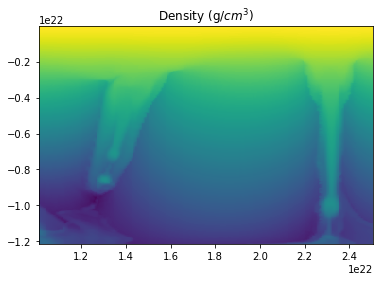

In [24]:
z=densityArrayZoom
plt.title("Density (g/$cm^3$)")
lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarrayZoom, posYarrayZoom, z, locator=ticker.LogLocator(), levels = lev)

### 1.5 Velocity Vector Plots
Matplotlib has a built-in way to make vector plots.

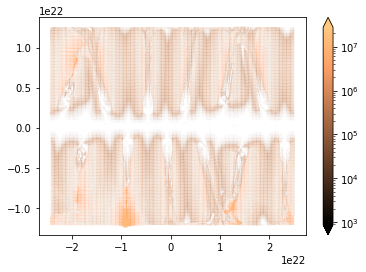

In [43]:
plt.clf
color = np.hypot(velXarray, velYarray)
#plt.tricontourf(posXarray, posYarray, densityArray, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.quiver(posXarray, posYarray, velXarray, velYarray, color, norm=matplotlib.colors.LogNorm(),
           width=0.001, minlength = 0.001, headwidth=0.25, headlength=0.5, 
            cmap = plt.get_cmap('copper'))
plt.colorbar(extend='both', orientation='vertical')

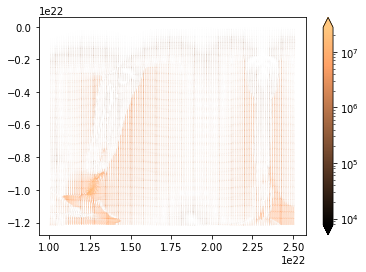

In [44]:
plt.clf
color = np.hypot(velXarrayZoom, velYarrayZoom)
#plt.tricontourf(posXarrayZoom, posYarrayZoom, densityArrayZoom, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.quiver(posXarrayZoom, posYarrayZoom, velXarrayZoom, velYarrayZoom, color, norm=matplotlib.colors.LogNorm(),
           width=0.001, minlength = 0.001, headwidth=0.25, headlength=0.5, 
            cmap = plt.get_cmap('copper'))
plt.colorbar(extend='both', orientation='vertical')

## 2. Plotting with YT
YT is a very powerful tool for plotting. Much of what we need can be more easily done in YT, but it is more difficult to fine-tune the back end of the data we feed into it.

It is *much* easier and cleaner to plot basic plots:

yt : [INFO     ] 2021-06-14 16:30:25,432 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-06-14 16:30:25,433 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-14 16:30:25,433 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-14 16:30:25,434 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-14 16:30:25,435 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-14 16:30:26,891 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-14 16:30:26,892 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-14 16:30:26,893 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-14 16:30:26,894 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-14 16:30:26,896 Ma


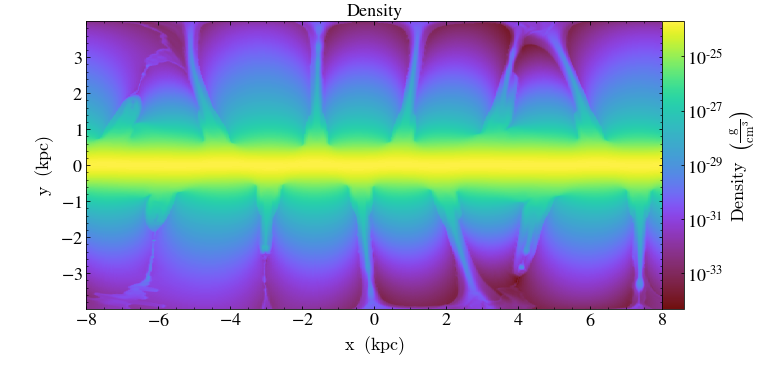

In [59]:
ds = yt.load(filename)
slc = yt.SlicePlot(ds, 'z', 'density')
slc.annotate_title("Density")

It is also easy to see all the included data:

In [47]:
for i in sorted(ds.field_list):
    print(i)
for i in sorted(ds.derived_field_list):
    print(i)

yt : [INFO     ] 2021-06-14 10:02:33,471 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-06-14 10:02:33,472 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-14 10:02:33,473 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-14 10:02:33,474 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-14 10:02:33,475 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-06-14 10:02:35,377 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-14 10:02:35,379 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-14 10:02:35,380 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-06-14 10:02:35,382 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-06-14 10:02:35,384 Ma

['I SHOULD NOT BE HERE_Slice_z_density.png']

### 2.1 Zooming in YT
With some guesswork (on plot centres), it is also easy to zoom into a part of the plot:

yt : [INFO     ] 2021-06-14 10:46:17,221 xlim = 3.100000 5.100000
yt : [INFO     ] 2021-06-14 10:46:17,222 ylim = -3.850000 -1.850000
yt : [INFO     ] 2021-06-14 10:46:17,224 xlim = 9565600500983204413440.000000 15736955662907853504512.000000
yt : [INFO     ] 2021-06-14 10:46:17,225 ylim = -11879858686704949919744.000000 -5708503524780300828672.000000
yt : [INFO     ] 2021-06-14 10:46:17,226 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-14 10:46:18,415 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



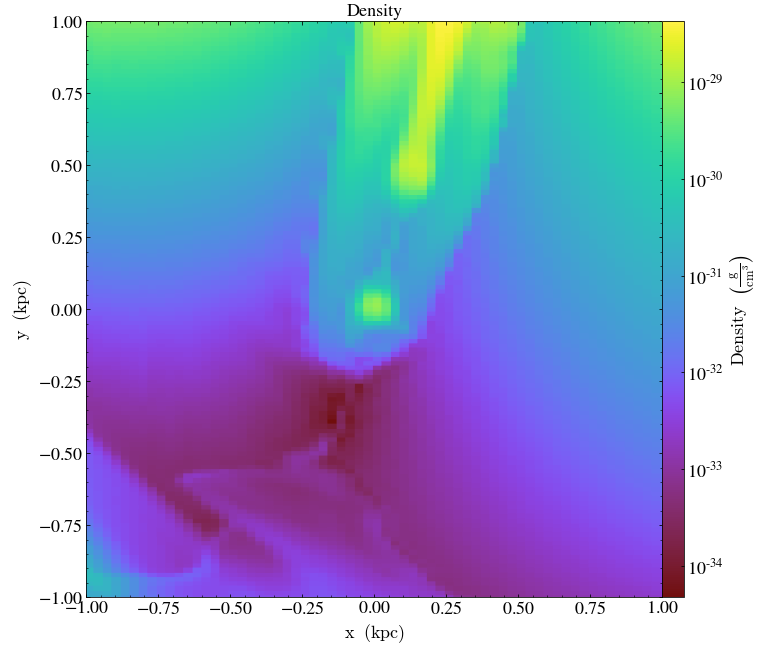

In [48]:
slc = yt.SlicePlot(ds, 'z', 'density', center=(4.1*kpc, -2.85*kpc, 0), width=(2*kpc, 2*kpc, 0)) #3D!!!
slc.set_width(2*kpc)
slc.annotate_title("Density")

Generally, this zooming strategy is janky and only works to navigate premade large plots. It is more difficult to, for example, select and examine the data only contained in the above box. The way to do this is to use YT Cut Regions.

yt : [INFO     ] 2021-06-14 10:46:32,447 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-14 10:46:32,448 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-14 10:46:32,449 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-14 10:46:32,450 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-14 10:46:32,451 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-14 10:46:32,752 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



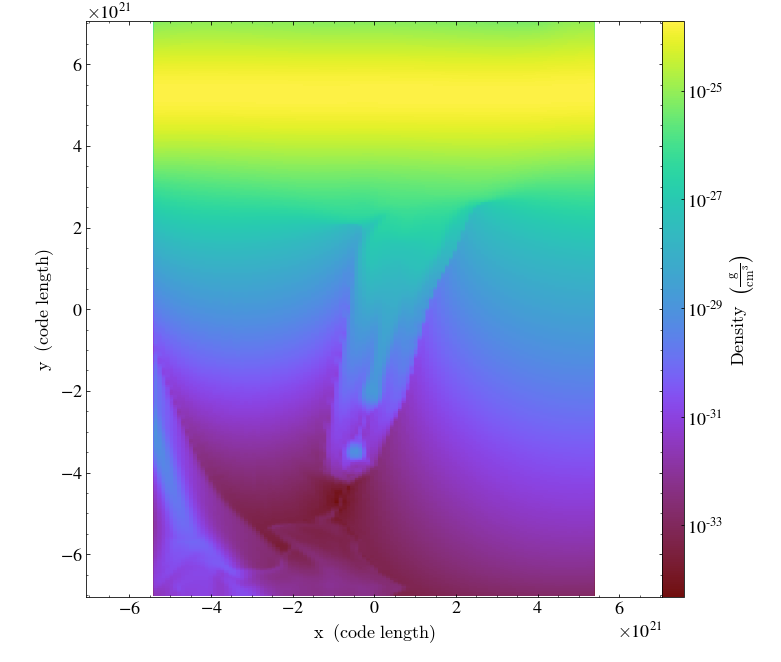

In [49]:
ad = ds.all_data()
conversion = 3.086e21 #kpc to cm
bounds = {'xmin': 2.5*conversion, 'xmax': 6*conversion, 'ymin': float(min(ad['y']).value),'ymax': 1.79040182984184e21}
dsSelect = ad.include_inside('x', bounds['xmin'], bounds['xmax'])
dsSelect = dsSelect.include_inside('y', bounds['ymin'], bounds['ymax'])
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))

Using a Cut Region allows us to manipulate the data that exists ONLY within these boundaries.

### 2.2 Velocity Vector Fields
YT has a built-in vector field plotting function.

yt : [INFO     ] 2021-06-14 10:55:06,263 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-14 10:55:06,264 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-14 10:55:06,268 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-14 10:55:06,269 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-14 10:55:06,271 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-14 10:55:06,619 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



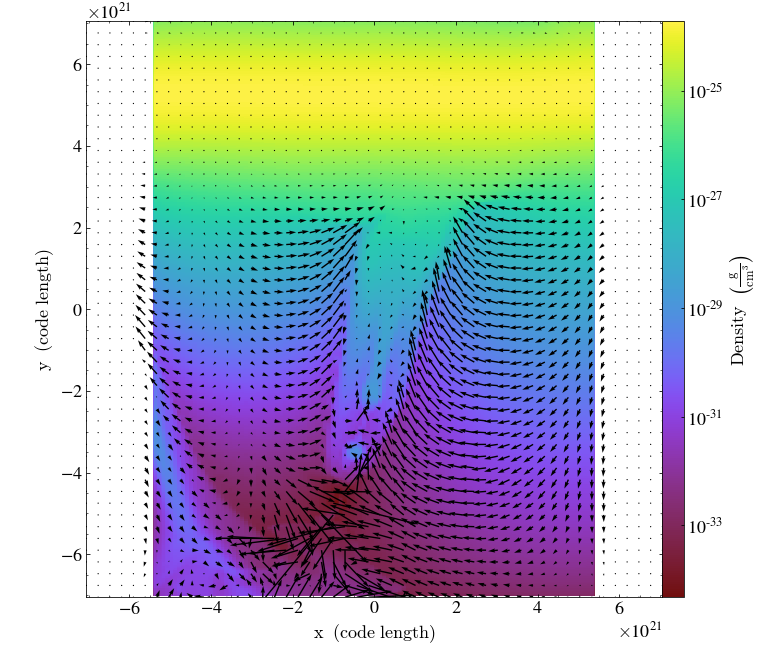

In [52]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_velocity(factor=16)

### 2.3 Streamlines
Streamlines allow us to more easily see trends in the vector fields:

yt : [INFO     ] 2021-06-14 10:56:04,495 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-14 10:56:04,496 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-14 10:56:04,497 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-14 10:56:04,498 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-14 10:56:04,503 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-14 10:56:04,857 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



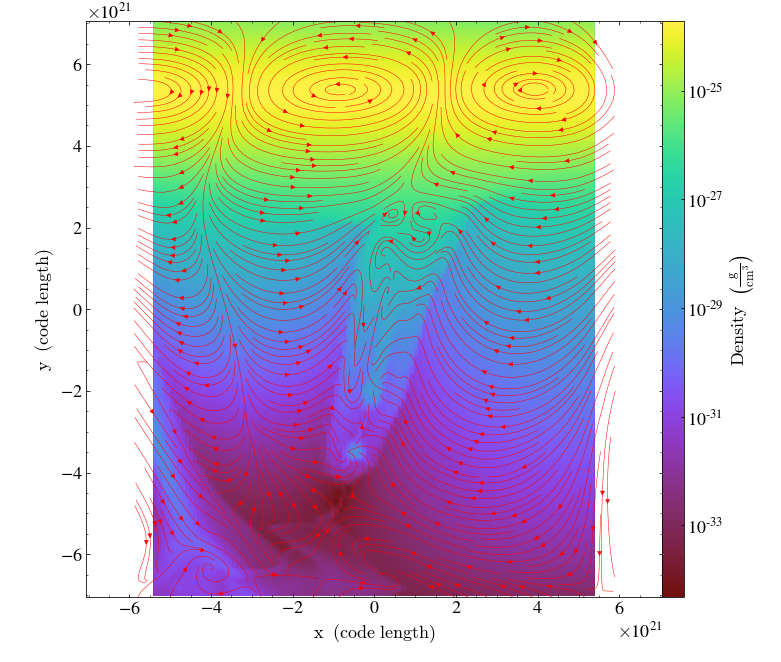

In [55]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_streamlines('velocity_x','velocity_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

We can do the same for the magnetic field in the system

yt : [INFO     ] 2021-06-14 10:56:08,232 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-14 10:56:08,233 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-14 10:56:08,234 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-06-14 10:56:08,235 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-06-14 10:56:08,236 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-06-14 10:56:08,554 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



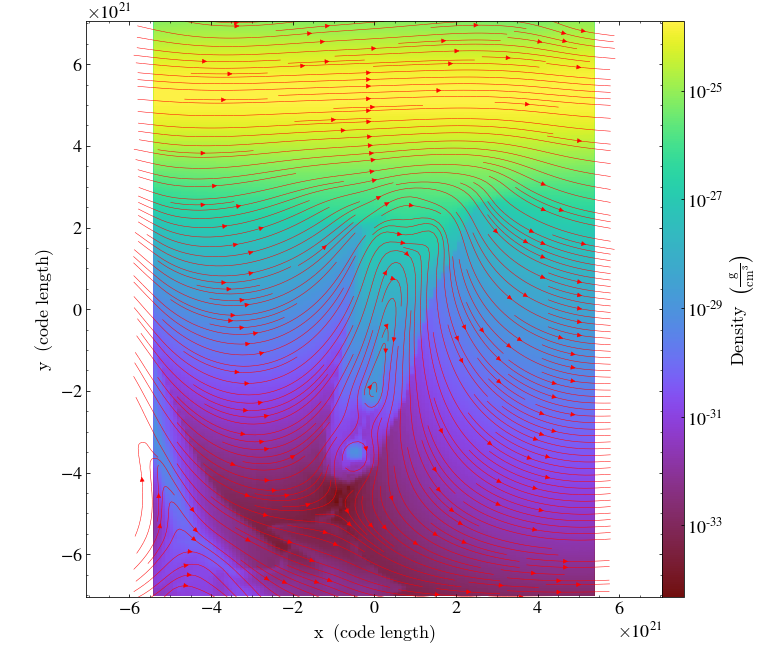

In [56]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_streamlines('magnetic_field_x','magnetic_field_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

### 2.4 Making Gifs
We can make gifs of the entire simulation by plotting information from every timestamp. then stitching them into a gif using an online tool like https://ezgif.com/maker or a python package moviepy.

Set your directory to the one containing your simulation output files. Set the save directory to where you want to save the many output image plots. Specify the field you want to plot. Expect this code to take a bit of time to run, about a few minutes.

In [51]:
directory = "/Users/wongb/Documents/URS Data/m2_c1_16x8_64x64/More Plot Files/"
saveDirectory = "D:/URS_LargeData/SherryPlots"

field = 'density'

In [ ]:
startTime = time.time()
for fileName in os.listdir(directory):
    #Find all simulation files. These files all start with parkerCRs,
    #e.g. parkerCRs_hdf5_plt_cnt_0076
    if(fileName.startswith("parkerCRs")):
        #Start
        print(fileName)
        timeStamp = fileName[len(fileName)-4: len(fileName)]
        ds = yt.load(directory+fileName)
        
        #SlicePlot
        slc = yt.SlicePlot(ds, 'z', field)
        # slc.annotate_velocity(factor=16)
        slc.annotate_title(timeStamp +" "+ field)
        plot = slc.plots[field]
        slc.set_zlim('density', 1e-33, 1e-24)
        # slc.annotate_streamlines('magnetic_field_x','magnetic_field_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

        #Finish
        #https://stackabuse.com/creating-and-deleting-directories-with-python/
        #Create a new save folder if one does not exist already
        if (not path.exists(saveDirectory + "/" + field)):
            os.mkdir(saveDirectory + "/" + field)
            
        ### Enable the below line for the code to save anything;
        ### Disabled for the sake of jupyter
        # # slc.save(saveDirectory + "/" + field + "/" + timeStamp)
beepy.beep(4)
print()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Plotting done. Time elapsed (sec): " + str(time.time()-startTime))

The below code will take the images in your chosen save directory, create a gif, and save it to the same directory. You can trim the beginning/end of the gif by deleting unwanted frames from the save directory.

In [ ]:
#https://www.tutorialexample.com/python-create-gif-with-images-using-moviepy-a-complete-guide-python-tutorial/

# images = []
# for fileName in os.listdir(saveDirectory + '/' + field): #set in initial parameters
#     images.append(saveDirectory + '/' + field + '/' + fileName)
# print(images)
# clip = ImageSequenceClip(images, fps=5)
# clip.write_gif(saveDirectory + '/' + field + '.gif') #saves in outside folder
# clip.close()
#DANGER!!! The line below removes the directory.
# # shutil.rmtree(saveDirectory + '/' + field) #delete images to save space


Combining this with our velocity streamlines, we get: 
<img src="densityFIXED_64x64.gif">

### 2.5 Total Mass
Using a similar loop as above to iterate through all simulations, we can easily keep track of the total mass contained in each frame of the simulation.

This code similarly takes a few minutes to run.

In [57]:
startTime = time.time()

# two axes to plot later
timeStamps = []
mass = []

#iterate through simulation files
for fileName in os.listdir(directory):
    if(fileName.startswith("parkerCRs")): #find all simulation files
        #Start
        print(fileName)
        #use the timestamp in the file name
        #e.g. parkerCRs_hdf5_plt_cnt_0076 --> 0076
        timeStamp = fileName[len(fileName)-4: len(fileName)]
        ds = yt.load(directory+fileName)
        ad = ds.all_data()
        timeStamps.append(int(timeStamp))
        mass.append(sum(ad[('gas', 'cell_mass')]))
beepy.beep(4)
print()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Mass calc done. Time elapsed (sec): " + str(time.time()-startTime))

plt.clf()
# upperTick = round( np.amax(mass) )
# bottomTick = round( np.amin(mass) )
# log = np.logspace(bottomTick, upperTick, 8)
# plt.plot(timeStamps, np.log10(mass))
plt.plot(timeStamps, mass)

parkerCRs_hdf5_plt_cnt_0000


yt : [INFO     ] 2021-06-14 10:59:47,942 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-06-14 10:59:47,943 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-14 10:59:47,944 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-14 10:59:47,945 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-14 10:59:47,946 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0001


yt : [INFO     ] 2021-06-14 10:59:55,026 Parameters: current_time              = 317264985381575.2
yt : [INFO     ] 2021-06-14 10:59:55,026 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-14 10:59:55,027 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-14 10:59:55,028 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-14 10:59:55,030 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0002


yt : [INFO     ] 2021-06-14 11:00:01,371 Parameters: current_time              = 631952027459833.6
yt : [INFO     ] 2021-06-14 11:00:01,372 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-14 11:00:01,372 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-14 11:00:01,373 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-14 11:00:01,374 Parameters: cosmological_simulation   = 0.0


parkerCRs_hdf5_plt_cnt_0003


yt : [INFO     ] 2021-06-14 11:00:07,780 Parameters: current_time              = 947866814238225.9
yt : [INFO     ] 2021-06-14 11:00:07,781 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-06-14 11:00:07,782 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-06-14 11:00:07,783 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-06-14 11:00:07,784 Parameters: cosmological_simulation   = 0.0


KeyboardInterrupt: 

#### Mass flux

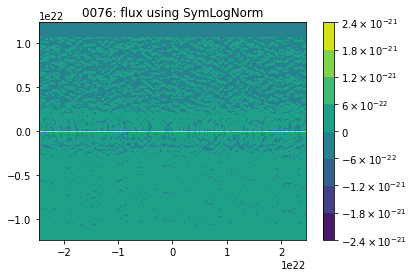

In [61]:
flux = ad['density']*ad['vely']
plt.tricontourf(ad['x'], ad['y'], flux, norm=matplotlib.colors.SymLogNorm(linthresh=0.01))
plt.title("0076: flux using SymLogNorm")
plt.colorbar()